### QSP Hadamard Approximation

**Aryan Bawa**  

In this notebook, I modify Pennylane.ai's "Function Fitting using Quantum Signal Processing" tutorial [here](https://pennylane.ai/qml/demos/function_fitting_qsp) such that I can approximate the action of a Hadamard gate. There are a few main things I change:

1. Outputting the full matrix for the circuit, not just the polynomial $ \langle 0 | U_{QSP}|0 \rangle $
2. Changing how we measure how accurate the approximation is by using Fidelity.

In [16]:
# have to do this because some libraries using OpenMP cause issues with multiple threads
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import pennylane as qml
import math
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# defining important functions
def rotation_mat(a):
    """Given a fixed value 'a', compute the signal rotation matrix W(a).
    (requires -1 <= 'a' <= 1)
    """
    diag = a
    off_diag = (1 - a**2) ** (1 / 2) * 1j
    W = [[diag, off_diag], [off_diag, diag]]

    return W

def generate_many_sro(a_vals):
    """Given a tensor of possible 'a' vals, return a tensor of W(a)"""
    w_array = []
    for a in a_vals:
        w = rotation_mat(a)
        w_array.append(w)

    return torch.tensor(w_array, dtype=torch.complex64, requires_grad=False)

def target_hadamard():
    """Return the target Hadamard matrix"""
    return torch.tensor([[1/np.sqrt(2), 1/np.sqrt(2)], 
                        [1/np.sqrt(2), -1/np.sqrt(2)]], 
                       dtype=torch.complex64)

# fidelity-based loss function for the QSP unitary fitting
def fidelity_loss(pred_unitaries, target_op):
    batch_size = pred_unitaries.shape[0]
    fidelities = []
    
    for i in range(batch_size):
        U_pred = pred_unitaries[i]
        U_target = target_op
        
        product = torch.matmul(torch.conj(U_pred).T, U_target)
        trace = torch.trace(product)
        fidelity = torch.abs(trace)**2 / 4.0
        fidelities.append(fidelity)
    
    avg_fidelity = torch.mean(torch.stack(fidelities))
    return 1.0 - avg_fidelity
    

# below is the QSP circuit itself - we don't change the basis this time since we don't need to use the relaxed third condition for QSP
@qml.qnode(qml.device("default.qubit", wires=1))
def QSP_circ(phi, W):
    for angle in phi[:-1]:
        qml.RZ(angle, wires=0)
        qml.QubitUnitary(W, wires=0)
    qml.RZ(phi[-1], wires=0)
    return qml.state()

The Pennylane article uses machine learning to fit specific $ \phi $ values such that the polynomial in $ \langle 0 | U_{QSP}|0 \rangle $ is approximately equal to some P(a). This is done by creating several classes for fitting and running the model. Starting with the fitting class:

In [18]:
torch_pi = torch.Tensor([math.pi])

class QSP_Unitary_Fit(torch.nn.Module):
    def __init__(self, degree, random_seed=None):
        """Given the degree and number of samples, this method randomly
        initializes the parameter vector (randomness can be set by random_seed)
        """
        super().__init__()
        if random_seed is None:
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True)

        else:
            gen = torch.Generator()
            gen.manual_seed(random_seed)
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True, generator=gen)

        self.phi = torch.nn.Parameter(self.phi)
        self.num_phi = degree + 1

    def forward(self, omega_mats):
        """PennyLane forward implementation"""
        unitary_pred = []
        generate_qsp_mat = qml.matrix(QSP_circ, wire_order=[0])

        for w in omega_mats:
            u_qsp = generate_qsp_mat(self.phi, w)
            unitary_pred.append(u_qsp)

        return torch.stack(unitary_pred, 0)

Next, the Model_Runner class handles running the optimization, storing the results, determining fidelity between approximate and target states, and plotting this metric.

In [21]:
# cleaned this up and added verbose output with Claude AI's help
class Model_Runner:
    def __init__(self, degree, num_samples):
        self.degree = degree
        self.num_samples = num_samples
        # generating a values and corresponding W(a) matrices
        self.a_vals = torch.linspace(-0.99, 0.99, num_samples)
        self.omega_mats = generate_many_sro(self.a_vals)
        self.target_op = target_hadamard()

        print(f"Initialized model runner")

    def execute(self, max_iterations=5000, lr=1e-3, random_seed=42, verbose=True):
        # starting up the model
        self.model = QSP_Unitary_Fit(self.degree, random_seed=random_seed)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        # storing the initial for comparison
        with torch.no_grad():
            self.init_pred = self.model(self.omega_mats)
        
        # Training tracking
        self.losses = []
        self.fidelities = []
        
        if verbose:
            print(f"\nTraining QSP to approximate Hadamard gate...")
            print(f"Learning rate: {lr}")
            print("-" * 50)
        
        for t in range(max_iterations):
            pred_unitaries = self.model(self.omega_mats)
            loss = fidelity_loss(pred_unitaries, self.target_op)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            current_loss = loss.item()
            current_fidelity = 1.0 - current_loss
            
            self.losses.append(current_loss)
            self.fidelities.append(current_fidelity)
            
            if verbose and (t % 500 == 0 or t < 10):
                print(f"Iteration {t:5d}: Loss = {current_loss:.8f}, Avg Fidelity = {current_fidelity:.8f}")
            
            # Early stopping for very high fidelity
            if current_fidelity > 0.9999:
                if verbose:
                    print(f"High fidelity achieved! Stopping at iteration {t}")
                break
            
            # Early stopping for convergence
            if current_loss < 1e-8:
                if verbose:
                    print(f"Converged at iteration {t}")
                break
        
        # Store final results
        self.final_loss = current_loss
        self.final_fidelity = current_fidelity
        self.training_iterations = len(self.losses)
        
        if verbose:
            print(f"\nTraining completed after {self.training_iterations} iterations")
            print(f"Final loss: {self.final_loss:.8f}")
            print(f"Final average fidelity: {self.final_fidelity:.8f}")

    def evaluate(self, verbose=True):
        """
        Evaluate the quality of the approximation
        """
        if not hasattr(self, 'model'):
            raise ValueError("Must run execute() before evaluate()")
        
        with torch.no_grad():
            self.final_pred = self.model(self.omega_mats)
        
        # Compute fidelities and errors for each 'a' value
        self.fidelities_per_a = []
        self.errors_per_a = []
        
        for i, a in enumerate(self.a_vals):
            U_pred = self.final_pred[i]
            
            # Use the SAME fidelity calculation as in fidelity_loss function
            product = torch.matmul(torch.conj(U_pred).T, self.target_op)
            trace = torch.trace(product)
            fidelity = (torch.abs(trace)**2 / 4.0).item()
            self.fidelities_per_a.append(fidelity)
            
            # Frobenius error for additional analysis
            diff = U_pred - self.target_op
            frobenius_error = torch.sqrt(torch.sum(torch.abs(diff)**2)).item()
            self.errors_per_a.append(frobenius_error)
        
        # Compute statistics
        self.avg_fidelity = np.mean(self.fidelities_per_a)
        self.min_fidelity = np.min(self.fidelities_per_a)
        self.max_fidelity = np.max(self.fidelities_per_a)
        self.std_fidelity = np.std(self.fidelities_per_a)

        
        if verbose:
            print(f"\n=== Hadamard Gate Approximation Quality ===")
            print(f"Average Fidelity:     {self.avg_fidelity:.8f}")
            print(f"Minimum Fidelity:     {self.min_fidelity:.8f}")
            print(f"Maximum Fidelity:     {self.max_fidelity:.8f}")
            print(f"Fidelity Std Dev:     {self.std_fidelity:.8f}")


    def plot_results(self, show=True, figsize=(15, 5)):
        """
        Plot comprehensive training and evaluation results
        """
        if not hasattr(self, 'losses'):
            raise ValueError("Must run execute() before plotting")
        
        if not hasattr(self, 'fidelities_per_a'):
            self.evaluate(verbose=False)
        
        plt.figure(figsize=figsize)
        
        # Plot 1: Training progress
        plt.subplot(1, 3, 1)
        plt.plot(self.losses, label='Loss', color='red', alpha=0.7)
        plt.plot(self.fidelities, label='Avg Fidelity', color='blue', alpha=0.7)
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Training Progress')
        plt.legend()
        plt.yscale('log')
        plt.grid(True)
        
        if show:
            plt.show()

    def get_learned_parameters(self):
        """
        Get the learned φ parameters
        """
        if not hasattr(self, 'model'):
            raise ValueError("Must run execute() before getting parameters")
        return self.model.phi.detach().numpy()

Finally, we can actually run the model to approximate a Hadamard:

Initialized model runner

Training QSP to approximate Hadamard gate...
Learning rate: 0.01
--------------------------------------------------
Iteration     0: Loss = 0.95505852, Avg Fidelity = 0.04494148
Iteration     1: Loss = 0.95009172, Avg Fidelity = 0.04990828
Iteration     2: Loss = 0.94488645, Avg Fidelity = 0.05511355
Iteration     3: Loss = 0.93944752, Avg Fidelity = 0.06055248
Iteration     4: Loss = 0.93377995, Avg Fidelity = 0.06622005
Iteration     5: Loss = 0.92788899, Avg Fidelity = 0.07211101
Iteration     6: Loss = 0.92178029, Avg Fidelity = 0.07821971
Iteration     7: Loss = 0.91545975, Avg Fidelity = 0.08454025
Iteration     8: Loss = 0.90893394, Avg Fidelity = 0.09106606
Iteration     9: Loss = 0.90220982, Avg Fidelity = 0.09779018
Iteration     7: Loss = 0.91545975, Avg Fidelity = 0.08454025
Iteration     8: Loss = 0.90893394, Avg Fidelity = 0.09106606
Iteration     9: Loss = 0.90220982, Avg Fidelity = 0.09779018
Iteration   500: Loss = 0.50010407, Avg Fidelity = 0

Initialized model runner

Training QSP to approximate Hadamard gate...
Learning rate: 0.01
--------------------------------------------------
Iteration     0: Loss = 0.95505852, Avg Fidelity = 0.04494148
Iteration     1: Loss = 0.95009172, Avg Fidelity = 0.04990828
Iteration     2: Loss = 0.94488645, Avg Fidelity = 0.05511355
Iteration     3: Loss = 0.93944752, Avg Fidelity = 0.06055248
Iteration     4: Loss = 0.93377995, Avg Fidelity = 0.06622005
Iteration     5: Loss = 0.92788899, Avg Fidelity = 0.07211101
Iteration     6: Loss = 0.92178029, Avg Fidelity = 0.07821971
Iteration     7: Loss = 0.91545975, Avg Fidelity = 0.08454025
Iteration     8: Loss = 0.90893394, Avg Fidelity = 0.09106606
Iteration     9: Loss = 0.90220982, Avg Fidelity = 0.09779018
Iteration     7: Loss = 0.91545975, Avg Fidelity = 0.08454025
Iteration     8: Loss = 0.90893394, Avg Fidelity = 0.09106606
Iteration     9: Loss = 0.90220982, Avg Fidelity = 0.09779018
Iteration   500: Loss = 0.50010407, Avg Fidelity = 0

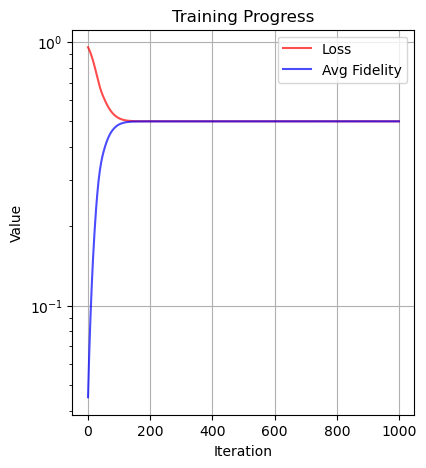


=== Final Results ===
Learned φ parameters: [3.565692  3.241349  2.070773  2.8037655 2.2006905 1.8083417]
Parameter range: [1.8083, 3.5657]
Training iterations: 1000


Initialized model runner

Training QSP to approximate Hadamard gate...
Learning rate: 0.01
--------------------------------------------------
Iteration     0: Loss = 0.95505852, Avg Fidelity = 0.04494148
Iteration     1: Loss = 0.95009172, Avg Fidelity = 0.04990828
Iteration     2: Loss = 0.94488645, Avg Fidelity = 0.05511355
Iteration     3: Loss = 0.93944752, Avg Fidelity = 0.06055248
Iteration     4: Loss = 0.93377995, Avg Fidelity = 0.06622005
Iteration     5: Loss = 0.92788899, Avg Fidelity = 0.07211101
Iteration     6: Loss = 0.92178029, Avg Fidelity = 0.07821971
Iteration     7: Loss = 0.91545975, Avg Fidelity = 0.08454025
Iteration     8: Loss = 0.90893394, Avg Fidelity = 0.09106606
Iteration     9: Loss = 0.90220982, Avg Fidelity = 0.09779018
Iteration     7: Loss = 0.91545975, Avg Fidelity = 0.08454025
Iteration     8: Loss = 0.90893394, Avg Fidelity = 0.09106606
Iteration     9: Loss = 0.90220982, Avg Fidelity = 0.09779018
Iteration   500: Loss = 0.50010407, Avg Fidelity = 0

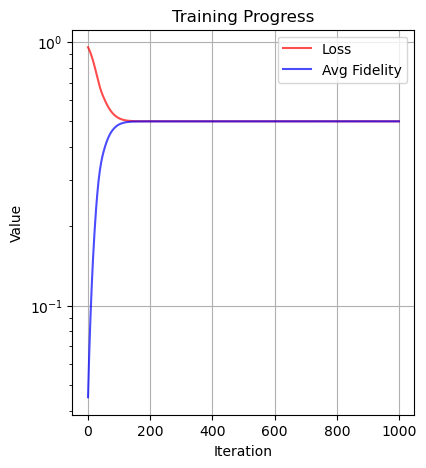


=== Final Results ===
Learned φ parameters: [3.565692  3.241349  2.070773  2.8037655 2.2006905 1.8083417]
Parameter range: [1.8083, 3.5657]
Training iterations: 1000


AttributeError: 'Model_Runner' object has no attribute 'compare_matrices'

In [22]:
# Initialize the runner
runner = Model_Runner(degree=5, num_samples=10)

# Execute training
runner.execute(max_iterations=1000, lr=1e-2, random_seed=42)

# Evaluate the results
runner.evaluate()

# Plot comprehensive results
runner.plot_results()

# Display learned parameters and additional analysis
print(f"\n=== Final Results ===")
learned_params = runner.get_learned_parameters()
print(f"Learned φ parameters: {learned_params}")
print(f"Parameter range: [{learned_params.min():.4f}, {learned_params.max():.4f}]")
print(f"Training iterations: {runner.training_iterations}")

In [27]:
# Test to verify fidelity calculations are consistent
print("Testing fidelity calculation consistency...")

# Create a simple test case
test_matrix = torch.tensor([[0.7071+0j, 0.7071+0j], [0.7071+0j, -0.7071+0j]], dtype=torch.complex64)
target = target_hadamard()

# Method 1: Our training loss calculation
product = torch.matmul(torch.conj(test_matrix).T, target)
trace = torch.trace(product)
our_fidelity = (torch.abs(trace)**2 / 4.0).item()

# Method 2: PennyLane's fidelity (for comparison)
pennylane_fidelity = qml.math.fidelity(test_matrix.numpy(), target.numpy(), check_state=False, c_dtype="complex128")

print(f"Our fidelity calculation: {our_fidelity:.8f}")
print(f"PennyLane fidelity: {pennylane_fidelity:.8f}")
print(f"Difference: {abs(our_fidelity - pennylane_fidelity):.8f}")

if abs(our_fidelity - pennylane_fidelity) < 1e-6:
    print("✅ Fidelity calculations are consistent!")
else:
    print("❌ Fidelity calculations differ - there may still be an issue")

Testing fidelity calculation consistency...
Our fidelity calculation: 0.99998069
PennyLane fidelity: 0.99999036
Difference: 0.00000967
❌ Fidelity calculations differ - there may still be an issue

Testing with perfect Hadamard matrix:
Perfect Hadamard fidelity: 0.99999988
Should be 1.0: False
